# はじめに

運営の皆様、新しいコンペの開催ありがとうございます。自然言語処理に挑戦したことが無いのでコンペに参加しながら勉強したいと思います。

上述の通り自然言語処理は初めてですが、ネット上の情報を寄せ集めてひとまず自分の中でBaselineと呼べるものができたので、今朝までの私と同じような「自然言語処理って何からすれば良いの？」という方の参考になれば幸いです。

また、付け焼刃の知識ですので、**間違った知識やよろしくない処理が含まれていると思います。不慣れな方は信じすぎず**、詳しい方はコメントで教えて頂けると大変幸いです。

# 参考にしたサイト

Baseline作成に当たり、以下のサイトを参考にしました。特にkaggleの方はまだまだ読み切っていませんが、当コンペでも役立つ情報が多そうです。

[Kaggle:SMS Spam Collection Dataset](https://www.kaggle.com/uciml/sms-spam-collection-dataset/notebooks)  
[Qiita:機械学習 〜 迷惑メール分類（ナイーブベイズ分類器） 〜](https://qiita.com/fujin/items/50fe0e0227ef8457a473)

# データとライブラリのインポート

In [1]:
import re
import string
import warnings
from collections import Counter

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from bs4 import BeautifulSoup
from imblearn.under_sampling import RandomUnderSampler
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from wordcloud import STOPWORDS, WordCloud

warnings.simplefilter("ignore")

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



In [ ]:
train = pd.read_csv("train_data.csv")
test = pd.read_csv("test_data.csv")

In [ ]:
# testにもyが無いとあとあと処理が厄介なので、-1を入れておく
test["y"] = -1

In [ ]:
# trainとtestをいったん合体
df = pd.concat([train,test])

In [ ]:
df.head()

In [13]:
test[test['contents'].str.contains('ect')]["contents"]

0        Subject: re : weather and energy price data\r\...
1        Subject: organizational study\r\ngpg and eott ...
2        Subject: re [ 7 ] : talk about our meds\r\nske...
3        Subject: report about your cable service\r\nhi...
4        Subject: start date : 1 / 26 / 02 ; hourahead ...
                               ...                        
24833    Subject: savvy players would be wise to | 0 ad...
24834    Subject: it ' s mariah from dating service\r\n...
24835    Subject: meter 9699\r\njackie -\r\ni cannot fo...
24836    Subject: presentation for cal berkeley\r\nhell...
24837    Subject: we are giving away ipod mini ' s !\r\...
Name: contents, Length: 24838, dtype: object

# 前処理①

## stopwordsの定義更新
stopwordsとは、日本語で言えば「は」、「です」など、英語で言えば「a」、「is」などの**出現頻度が高いにも関わらず特別な意味を持たない単語**のことで、こういった単語を削除することで認識精度を向上させます。  
nltkライブラリに基本的なものは格納されていますが、こちらは要するに単なるlistなので、自分でstopwordsを追加することもできます。  
以下では、`string.punctuation`で取得できる記号と、rawデータを見て無駄そうだった"Subject"も加えています。

以下の処理の際、私の環境（Anaconda上のjupyter notebook）ですとpip installできていたと思ってもエラーが起きました。
Anacondaでうまく動かないときは以下もご参照ください。  
https://stackoverflow.com/questions/48385829/how-to-install-stop-words-package-for-anaconda

In [ ]:
stop = set(stopwords.words("english"))

# string.punctuation = ['!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~']
punctuation = list(string.punctuation)

# 手動で追加
org_stop = ["subject"]

# stopwordsの定義更新
add_stop = punctuation + org_stop
stop.update(add_stop)

## 前処理の適用
stopwordsの削除の他、URLの削除などを行おうとしていますが…URLの削除については元データのURLに空白が含まれる様で、上手くいっていません。現状これを修正する実装力が無いので放置しています。  
また、remove_stopwords()関数の中で、PorterStemmer()を使った処理をコメントアウトしています。これは英単語の語幹を取り出すStemmingという処理を提供するもので、例えば"liked"を"like"に変えたりしてくれて、特徴数を減らせる良い処理ができそうですが、"October"を"Octob"に変換してしまったりと、少し頑張り過ぎる機能の様です（パラメータ次第で調整できるのかも知れません）。今のところはこのまま適用するとLBが下がってしまうので使わないことにしています。


### 正規表現について
全然覚えられないのでメモしておきます。

|正規表現等|内容|
|:---:|:---|
|re.sub|正規表現を使ってreplace|
|\\|エスケープ。特殊文字にマッチできるようにする。<br>例えば[abc]は"a"または"b"または"c"を表すが、\\ [abc\\]は"[abc]"そのものを表す。|
|[ ]|文字の集合を指定するのに使う。[amk]は"a"または"m"または"k"にマッチする。|
|^ / [^]|前者は行頭。例えば^abcはabcで始まる文字列にマッチするが、文中のabcにはマッチしない。<br>後者は否定。[0-9]は任意の数字1文字を表すが、[^0-9]は任意の数字"以外"1文字を表す。|
|\S|空白ではない任意の文字。|
|*|直前の正規表現を0回以上繰り返したもの。|
|+|直前の正規表現を1回以上繰り返したもの。<br>例えばab+は"a"に1つ以上の"b"が続いたもので、単なる"a"にはマッチしない。|
|r|エスケープシーケンス（\\）をそのままの文字列として認識する。<br>|

In [ ]:
# htmlの分割
# htmlオブジェクトからBeautifulSoupオブジェクトにすることで、html要素（titleなど）を取得できる
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

# 小文字にする
def text_lower(text):
    return text.lower()

# []で囲まれた、]以外の任意の複数文字の削除（脚注など）
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

# URLの削除
def remove_links(text):
    return re.sub(r'http\S+', '', text)

# stopwordsの削除/活用形の変換（は精度が落ちそうなのでコメントアウト）
def remove_stopwords(text):
#     ps = PorterStemmer()
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            if i.strip().isalpha():
                final_text.append(i.strip())
#     final_text = [ps.stem(word) for word in final_text]
    return " ".join(final_text)

# ↑の関数をまとめて適用する関数
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_links(text)
    text = text_lower(text)
    text = remove_stopwords(text)
    return text

# ↑の関数の適用
df['contents']=df['contents'].apply(denoise_text)

In [32]:
df

,id,contents,y
0,1,fw willis phillips spoke lavo said thing plann...,0
1,2,factor loadings primary curves tanya went comp...,0
2,3,meridian phone kate symes bill done mid aftern...,0
3,4,october wellhead vance deal created entered si...,0
4,5,california executive summary cpuc rules socal ...,0
...,...,...,...
24833,24834,savvy players would wise ad eariy wysak petrol...,-1
24834,24835,mariah dating service mariah girl next door im...,-1
24835,24836,meter jackie cannot life remember sale deal be...,-1
24836,24837,presentation cal berkeley hello vince john wan...,-1


# EDA

## targetの分布の確認

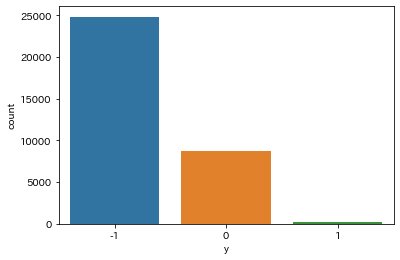

In [33]:
sns.countplot(df["y"])

ほとんどが非スパムで、非常に不均衡なデータです

## spamと非spam、test（yが1でも0でもない）に分けてWordCloudを確認
WordColudは「実装したことは無いけど見たことはある」人も多いのではないでしょうか。出現頻度が高い単語ほど大きく、そうでない単語ほど小さく表示し、直感的にどういった単語が多い文章か分かる様になってます。

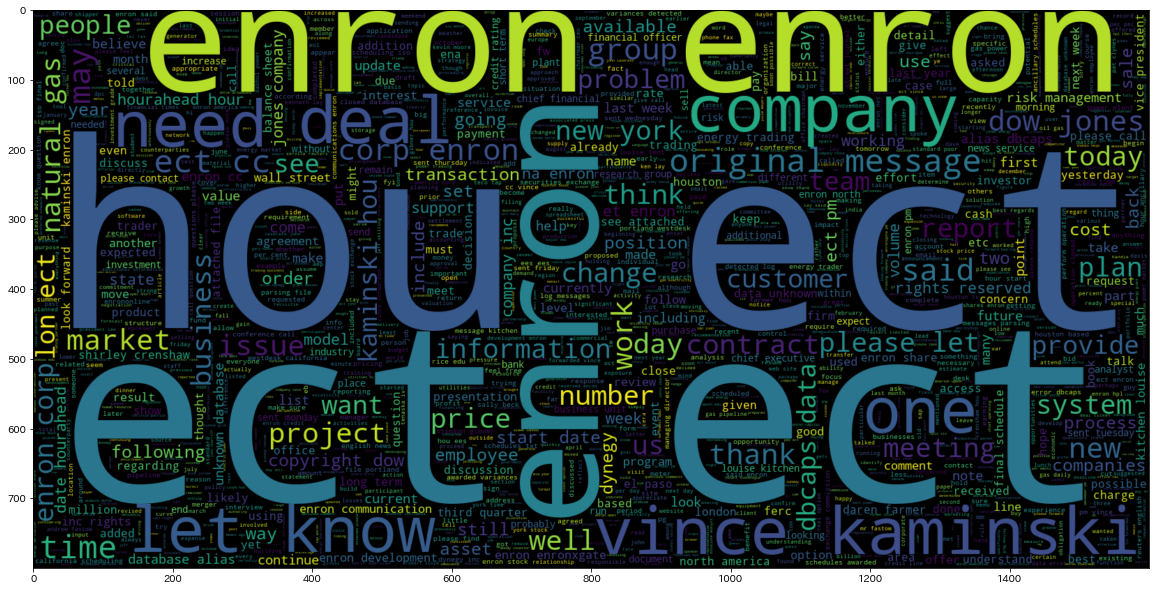

In [34]:
# 非spam
plt.figure(figsize=(20,20))
wc = WordCloud(max_words = 2000, width = 1600, height = 800, stopwords = STOPWORDS).generate(" ".join(df[df.y == 0].contents))
plt.imshow(wc, interpolation="bilinear")

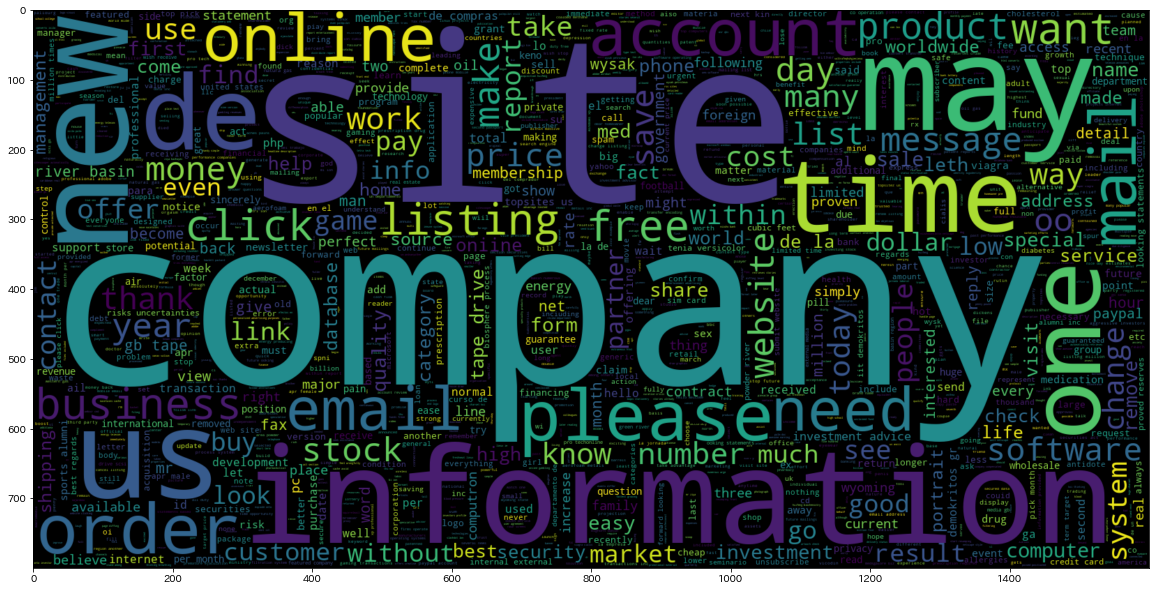

In [35]:
# spam
plt.figure(figsize=(20,20))
wc = WordCloud(max_words = 2000, width = 1600, height = 800, stopwords = STOPWORDS).generate(" ".join(df[df.y == 1].contents))
plt.imshow(wc, interpolation="bilinear")

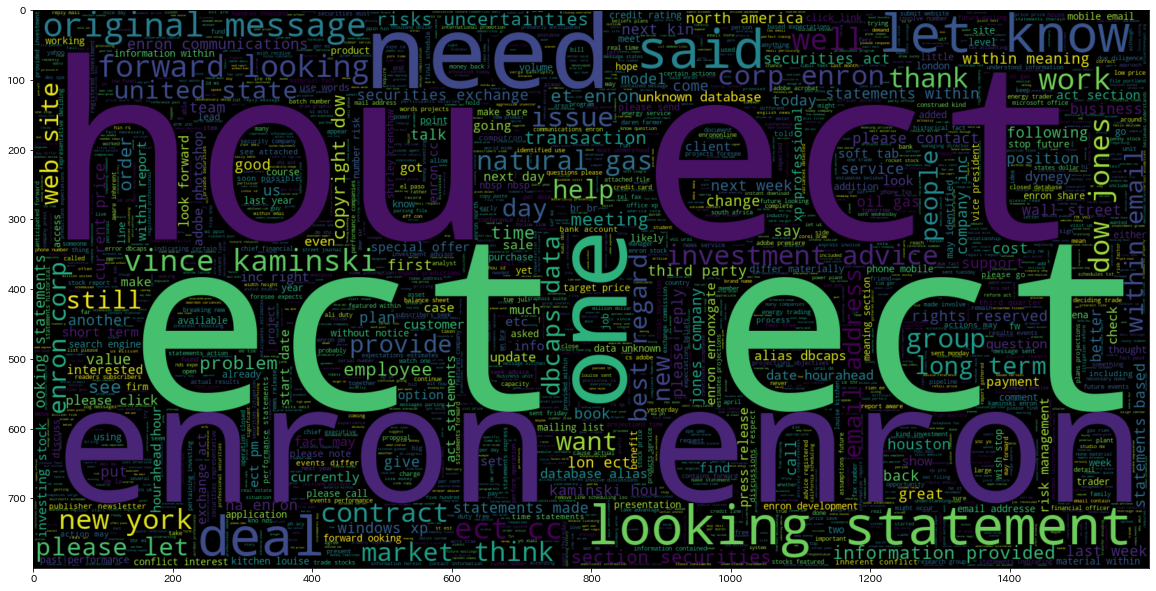

In [36]:
# test
plt.figure(figsize=(20,20))
wc = WordCloud(max_words = 2000, width = 1600, height = 800, stopwords = STOPWORDS).generate(" ".join(df[df.y == -1].contents))
plt.imshow(wc, interpolation="bilinear")

特に非spamの方は固有名詞？と思われる謎の単語が多そうです。testデータにも同じ単語が多そうなので、y=0のデータについては似たようなサンプル群を分割していると推察されます。ただし、testにはy=1となるデータも含まれている点に注意が必要です。  
spamの方は何か買わせようとしている様子が伺えます。

## 文章の長さがspamか否かに関係がありそうか

In [37]:
df["length"] = df["contents"].apply(len)
df.head()

,id,contents,y,length
0,1,fw willis phillips spoke lavo said thing plann...,0,258
1,2,factor loadings primary curves tanya went comp...,0,999
2,3,meridian phone kate symes bill done mid aftern...,0,246
3,4,october wellhead vance deal created entered si...,0,357
4,5,california executive summary cpuc rules socal ...,0,2130


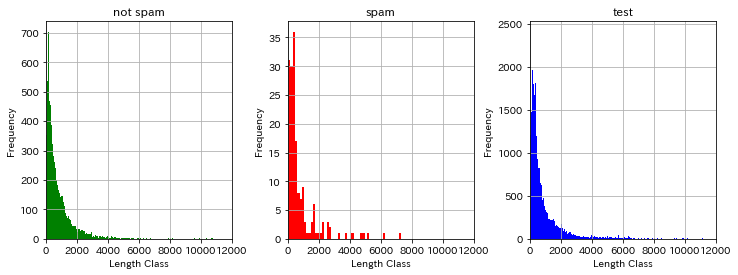

In [38]:
fig,ax = plt.subplots(1,3,figsize=(12,4))

df[df["y"]==0].hist(column="length", bins=2500, ax=ax[0], color = "green")
ax[0].set(xlabel = "Length Class", ylabel = "Frequency", title = "not spam")
ax[0].set_xlim([0,12000])

df[df["y"]==1].hist(column="length", bins=50, ax=ax[1], color = "red")
ax[1].set(xlabel = "Length Class", ylabel = "Frequency", title = "spam")
ax[1].set_xlim([0,12000])

df[df["y"]==-1].hist(column="length", bins=2500, ax=ax[2], color = "blue")
ax[2].set(xlabel = "Length Class", ylabel = "Frequency", title = "test")
ax[2].set_xlim([0,12000])

plt.show()

In [39]:
# 文章の長さの差を数値でも確認
df.groupby("y")["length"].mean()

y
-1     967.544126
 0    1068.221316
 1     810.426901
Name: length, dtype: float64

spamの方が文字数は少ない？が分布はそう変わらない様に見えます  
testはspamと非spamが混ざっているからか、中間くらいの長さです

## 単語の多さがspamか否かに関係がありそうか

In [40]:
df["words"] = df["contents"].str.split().map(lambda x: len(x))
df.head()

,id,contents,y,length,words
0,1,fw willis phillips spoke lavo said thing plann...,0,258,41
1,2,factor loadings primary curves tanya went comp...,0,999,152
2,3,meridian phone kate symes bill done mid aftern...,0,246,38
3,4,october wellhead vance deal created entered si...,0,357,57
4,5,california executive summary cpuc rules socal ...,0,2130,286


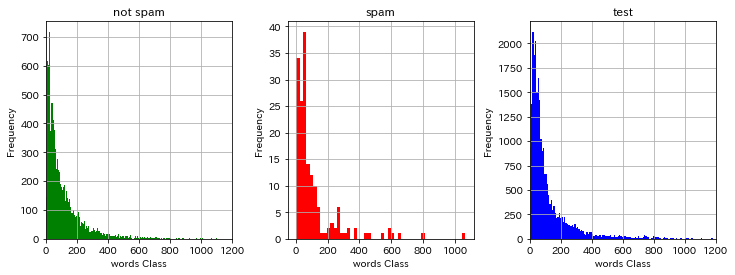

In [41]:
fig,ax = plt.subplots(1,3,figsize=(12,4))

df[df["y"]==0].hist(column="words", bins=2500, ax=ax[0], color = "green")
ax[0].set(xlabel = "words Class", ylabel = "Frequency", title = "not spam")
ax[0].set_xlim([0,1200])

df[df["y"]==1].hist(column="words", bins=50, ax=ax[1], color = "red")
ax[1].set(xlabel = "words Class", ylabel = "Frequency", title = "spam")

df[df["y"]==-1].hist(column="words", bins=2500, ax=ax[2], color = "blue")
ax[2].set(xlabel = "words Class", ylabel = "Frequency", title = "test")
ax[2].set_xlim([0,1200])

plt.show()

In [42]:
# 単語の多さの差を数値でも確認
df.groupby("y")["words"].mean()

y
-1    136.138175
 0    152.394051
 1    113.017544
Name: words, dtype: float64

こちらもlengthと同様ですね

## 連続した単語の出現頻度を見る【非spamのみ】

### 1単語の出現頻度【非spam】

In [43]:
# 出現単語をlist化
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(df.contents)

# 関数の効果の確認
# 作成したlistの最初の方 = dfの最初の方の文章の単語が並んでいる
print(corpus[:5])
df.head(1)

['fw', 'willis', 'phillips', 'spoke', 'lavo']


,id,contents,y,length,words
0,1,fw willis phillips spoke lavo said thing plann...,0,258,41


In [44]:
# 単語出現数のカウント
corpus = get_corpus(df[df.y==0].contents)
counter = Counter(corpus)
most_common = counter.most_common(10) # 引数xを変えてTop x までを辞書化
most_common = dict(most_common)

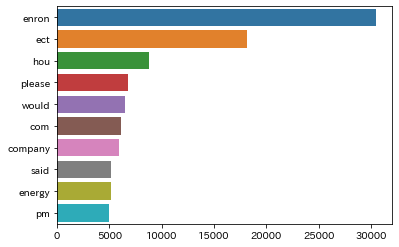

In [45]:
sns.barplot(x=list(most_common.values()),y=list(most_common.keys()))
plt.show()

謎の固有名詞？は何でしょうか…rawデータを見ると、メールのto:に続いていることが多そうで、enron/ect/houさんという人宛のメールがtrainには多そうです。

### 連続する2単語の出現頻度【非spam】

In [46]:
# 連続するg単語のtop n個を返す関数
def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

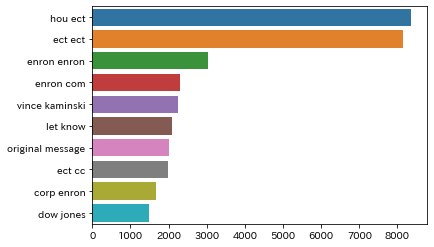

In [47]:
most_common_bi = get_top_text_ngrams(df[df.y==0].contents,10,2)
most_common_bi = dict(most_common_bi)
sns.barplot(x=list(most_common_bi.values()),y=list(most_common_bi.keys()))
plt.show()

enron/ect/houが人の名前（固有名詞）だとすると、ほとんど固有名詞とメールに良く付く単語ですね。  
固有名詞は評価用データセットが全く違う人たちのやり取りだったら意味の無い情報ですが、後程見ますがtestを見る限りは同じ人たちのやりとりが混ざっていそうなのでそのままでも良さそうです。とはいえPBに使われるtestデータ次第でもあるので難しいところです。testデータがどう分割されてLBとPBに反映されるのか、コンペルールを読むだけでは分からなかったのですがどうなんでしょう？ 
また、メールに良くつく"cc ~ "などは意味の無い情報の様にも思えますが、spamよりも往復のやり取りしたメールについている可能性の方が高そうなので、残しておいた方が良い気もします。

### 連続する3単語の出現頻度【非spam】

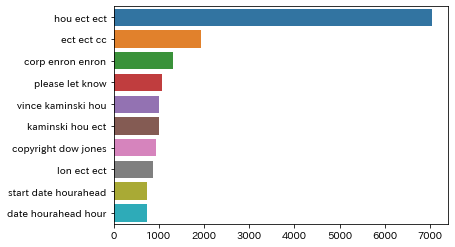

In [48]:
most_common_tri = get_top_text_ngrams(df[df.y==0].contents,10,3)
most_common_tri = dict(most_common_tri)
sns.barplot(x=list(most_common_tri.values()),y=list(most_common_tri.keys()))

まだまだhou/ect/enronさん（？）が強いです…続いてspamメールに絞って確認してみることにします。

## 1~2の連続した単語の出現頻度を見る【spamのみ】

### 1単語の出現頻度【spam】

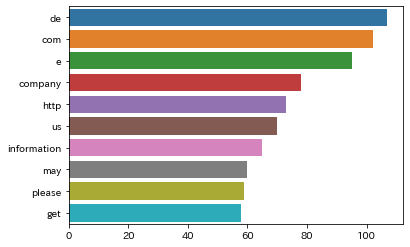

In [49]:
corpus = get_corpus(df[df.y==1].contents)
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
sns.barplot(x=list(most_common.values()),y=list(most_common.keys()))
plt.show()

固有名詞の様なものは無くなりました。やはり謎の単語や固有名詞だった様です。httpなどは削除したと思っていたのですが…rawデータを確認するとURLにスペースが入っているデータが多く前処理をやりなおす必要がありそう…が、未実装です。うまくURLのところの空白だけ削除する方法が思いつかないので、前処理テクニック不足ですね。。

### 連続する2単語の出現頻度【spam】

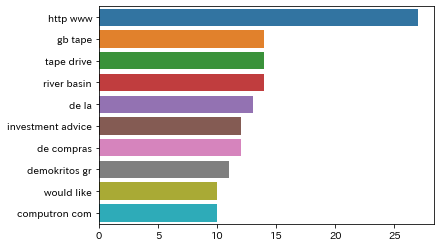

In [50]:
most_common_bi = get_top_text_ngrams(df[df.y==1].contents,10,2)
most_common_bi = dict(most_common_bi)
sns.barplot(x=list(most_common_bi.values()),y=list(most_common_bi.keys()))
plt.show()

完全にURLが残ってしまっていますね…あとは英語じゃない？spamメールもありそうです。

## 連続した単語の出現頻度を見る【testのみ】

### 1単語の出現頻度【test】

In [51]:
# 単語出現数のカウント
corpus = get_corpus(df[df.y==-1].contents)
counter = Counter(corpus)
most_common = counter.most_common(10) # 引数xを変えてTop x までを辞書化
most_common = dict(most_common)

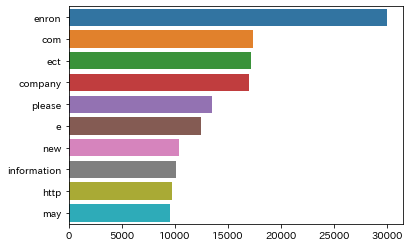

In [52]:
sns.barplot(x=list(most_common.values()),y=list(most_common.keys()))
plt.show()

またenronさんたちが出てきました。enronさんたちが出てくるメールはtrain同様であればy==0のデータと思われ、非spamのメールについてはtrainとtestで似たようなデータセットから分割されて作成された模様です。  
一方で、y==1のデータも増えた（17,000/24,838）せいか、spamのWordColudで確認したような単語もTop10に出てきています。spamメールもtrainとtestで似たようなデータセットからの作成、かつ全てで17171件のデータがあるとは言え、あまりバリエーションが無いのかも知れません。

### 連続する2単語の出現頻度【test】

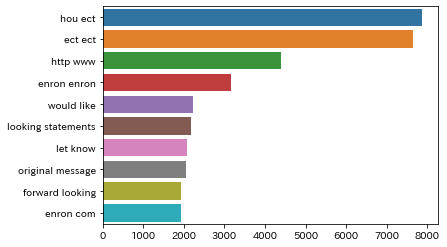

In [53]:
most_common_bi = get_top_text_ngrams(df[df.y==-1].contents,10,2)
most_common_bi = dict(most_common_bi)
sns.barplot(x=list(most_common_bi.values()),y=list(most_common_bi.keys()))
plt.show()

trainのspamと非spamの結果を合わせた様なグラフですね。
新しいもので気になるのは"forward + looking + statements"の組み合わせでしょうか。"forward looking statements"で「将来予測に関する記述」と訳され、英文のプレスリリースの最後の免責文言として良く使用されるそうです。企業からのメール？ということでspamか否か判断が難しいですね。

以下で答えの分かっているtrainから該当の言葉が含まれるデータを抜きだしてみます。

In [54]:
train[train['contents'].str.contains('forward looking statements')]

,id,contents,y
94,95,Subject: aggressive investors should be watchi...,1
811,812,Subject: market watch undervalued report f\r\n...,1


2件しかhitしませんでしたがいずれもspamに分類されています。確実なことは分かりませんがtestはspamの割合が多いので上位に挙がってきたのでは＝この言葉が含まれていたらspamの可能性が高い？と思われます。ちなみに、testに同様の処理を行うと491件がヒットします。

## その他

In [55]:
train[train.y==1]

,id,contents,y
66,67,Subject: information is key to sto - ck succes...,1
94,95,Subject: aggressive investors should be watchi...,1
151,152,Subject: portraits for commission from photos\...,1
171,172,Subject: microsoft autoroute 2005 dvd uk - $ 1...,1
172,173,Subject: failure notice\r\nhi . this is the qm...,1
...,...,...,...
8648,8649,Subject: = ? utf - 8 ? q ? only swiss rolex pl...,1
8711,8712,Subject: funny\r\nmay aplomb be angola may pri...,1
8759,8760,Subject: read : this email will change your li...,1
8839,8840,Subject: os - adobe - macromedia etc all under...,1


# 前処理②

## TF-IDF
[参考サイト] (https://dev.classmethod.jp/articles/yoshim_2017ad_tfidf_1-2/)  
レアな単語が何回も出てくるようなら、文書を分類する際にその単語の重要度を上げるアルゴリズム（？）とのこと。TFとIDFという概念が合体しており、
- TF = 文書Aにおける単語Xの出現頻度/文書Aにおける全単語の出現頻度の和
- IDF = log(全文書数/単語Xを含む文書数)  

で、TF-IDFはそれを掛け合わせたものなので（単語の出現頻度）*（各単語のレア度）を表します。

ここではBoW変換→TF-IDF変換器の宣言までに留め、これを用いた実際の学習・予測は後程行います。
出現率の考え方が加わるということで、df(train+testのDataFrame)ごと変換器を宣言しています。一方でBoW変換のみの方はtrainのみで変換器を宣言しています。LBの結果だけからこうしているのですが、どちらが正しい処理かはよく分かっていません。。  
オチを先に言うと、現状はBoWで予測したほうが1%強精度が良いですが、前処理やパラメータ次第で変わってくるかと思います。

### CountVectorizerについて
要するにBags-of-Wordsを作るためのものです。使い方はいわゆるscikit-learnチックで、初期化&fit(train)でtrainの単語map(?)みたいな下地を作り、transform(train)でその下地に実際にtrainの各単語のカウント数を格納するイメージかと思います。この場合、trainで下地を作っているので、transform(test)した際には新しい単語が出てきてもそれは無視されます。

ここではTF-IDF用なのでtestも含めた出現率で評価したほうが良いかと思いdf(trainとをtest結合したもの）に対してfitし、後程TF-IDF特徴量を使った予測の際もこちらを用いていますが、後程BoW予測をするときはサンプリングしたデータにfitさせています。単純にLBの結果がそれぞれその方が良さそうだったから…という理由だけでそうしていますが、汎用的にどちらが良いのかはまだ分かっていません。。

#### 初期化時の主要パラメータ
|パラメータ|説明|
|:---:|:---|
|min_df|最小出現文書数を指定することができ、小数の率、もしくは整数で指定します。「少しの文章にしか含まれない単語は意味がない」と考えるときに指定します。例えば"0.2"を指定した場合は20%以下の文章にしか出てこない単語は無視され、"3"を指定した場合は3文書以下しか出てこないときに無視されます。デフォルトは1（文書）。|
|max_df|min_dfの最大版。「どの文書にも出現するような単語は意味がない」と考えるときに指定します。"0.8"を指定した場合は80%以上の文書に出現する単語を、"50"を指定した場合は50文章以上に出現する単語を無視します。こちらもデフォルトは1（100%）。|
|stop_words|前処理①で出てきたstopwordsと機能としては同じものです。前処理で削除したはずなのですが、こちらで指定する/しないで結構数が変わるので指定しておきます。ntlkのものと中身を比べれば違いは分かるはずなのですが…面倒でやっていません。デフォルトはNone。|
|ngram_range|連続する単語をカウントの対象にするかを指定します。例えば、(1,2)だと1単語と2連続の単語までをカウントの対象とし、(2,2)だと2連続の単語のみを対象とします。デフォルトは(1,1)|


In [ ]:
# BoWに変換するとき同様カウント変換して…
bow_transformer = CountVectorizer(min_df=5, stop_words="english", ngram_range=(1,2)).fit(df["contents"])
contents_bow = bow_transformer.transform(df["contents"])

# 単語の種類の表示
print('word size: ', len(bow_transformer.vocabulary_))
# 先頭５件の単語を表示
print('word content: ', dict(list(bow_transformer.vocabulary_.items())[0:5]))

In [ ]:
# それをTF-IDF変換器に投げる
tfidf_transformer = TfidfTransformer().fit(contents_bow)
contents_tfidf = tfidf_transformer.transform(contents_bow)

# LSTMモデルの定義

# 学習・予測

## 分類器について
参考サイトをまねて、scikit-learnのナイーブベイズ分類器を使用しています。BernoulliNBとMultinomialNBが候補になりそうですが、ここでは単純に精度が良さそうだったMultinomialNBを使用しています。「二値分類はBernoulliNBを使う」といった情報や、「（BoW変換した後のような）スパースデータにはMultinomialNBが良い」などといった情報もあり、まだどちらを使うべきなのか分かっていません。。

その他、ニューラルネットワーク系統（LSTMなど）も候補になりそうなので今後学びたいと思います。

（追記）  
他のモデルも試し始めました。が、今のところやはりMultinomialNBが一番精度が良さそうです。
- MultinomialNB
- LogisticRegression
- RondomForestClassifier
- SVM

## バリデーションについて
極端な不均衡データかつtestはy==1が半分以上ということからか、`train_test_split()`でランダムに分割してしまうと全く精度が出なかったため、RandomUnderSamplerでアンダーサンプリングして正誤の数を同じにしています。サンプリングのrandom_stateをfor文で変えながら学習&予測して最終的に多数決で予測結果を決めていますが、訓練データに含まれるy==1のデータは毎回同じなので、素人ながら問題があると思っています。stratified k-foldも違う気がしますし、バリデーションはどの様に行うのが良いのでしょうか。。  
また、検証データはrandom_stateを訓練データと変えて取得しているのですが、こちらに含まれるy==1のデータは訓練データと同じものなので、更に問題が大きいです…  

（追記）  
[こちらのBlog](https://upura.hatenablog.com/entry/2019/01/12/193000)等でも触れられている通り、アンダーサンプリング+Baggingという手法自体は昔からある手法みたいです。検証データは`train_test_split()`で別途取得する方法も参考になります。ただ、訓練データのうちy==1のデータが毎回同じなことに対する解決策（そもそもそれが問題なのかも含めて）についてはまだ見つかっていないので、引き続き改善を目指します。

In [ ]:
# for loopする回数を指定
LOOP = 10

In [ ]:
# dfをtrainとtestに再分割
test = df.iloc[-len(test):,:2]
train = df.iloc[:len(train),:3]

In [ ]:
# trainデータを分割
X = pd.DataFrame(train['contents'])
y = pd.DataFrame(train['y'])

# testデータを分割
X_test = pd.DataFrame(test['contents'])

In [ ]:
# ラベルの割合が均等になる様にデータを学習用、検証用（もしくはテスト用）に分割する関数
def imbalanced_data_split(X, y, test_size=0.2):
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
    
    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        return X_train, X_test, y_train, y_test

In [ ]:
# アンダーサンプリングしたデータをStratifiedShuffleSplitして返す関数
def make_dataset(seed):
    sampler = RandomUnderSampler(random_state=seed, replacement=True)
    X_resampled, y_resampled = sampler.fit_resample(X, y)
    X_train2, X_valid, y_train2, y_valid = imbalanced_data_split(X_resampled, y_resampled, test_size=0.2)
    return X_train2, y_train2, X_valid, y_valid

## BoWを用いた予測

In [ ]:
seed = [i for i in range(LOOP)]

preds_nb = []
train_preds_nb = []
scores_nb = []

preds_logleg = []
train_preds_logleg = []
scores_logleg = []

preds_rf = []
train_preds_rf = []
scores_rf = []

preds_svm = []
train_preds_svm = []
scores_svm = []


for i in seed:
    print("SEED : ",i)

    X_train, y_train, X_val, y_val = make_dataset(i)
        
    # 単語の出現回数取得
    vec_count = CountVectorizer(min_df=2, stop_words="english", ngram_range=(1,2))
    vec_count.fit(X_train['contents'])

    # 単語の種類の表示
    print('word size: ', len(vec_count.vocabulary_))
    # 先頭５件の単語を表示
    print('word content: ', dict(list(vec_count.vocabulary_.items())[0:5]))
    
    # 訓練データと検証データをベクトル化
    X_train_vec = vec_count.transform(X_train['contents'])
    X_val_vec = vec_count.transform(X_val["contents"])
    
    #################### 学習 ####################
    # 多項モデルで学習
    model_nb = MultinomialNB()
    model_nb.fit(X_train_vec, y_train['y'])
    # ロジスティック回帰で学習
    model_logleg = LogisticRegression(solver="saga")
    model_logleg.fit(X_train_vec, y_train['y'])
    # RandomForest
    model_rf = RandomForestClassifier(random_state=0)
    model_rf.fit(X_train_vec, y_train['y'])
    # SVM 
    model_svm = SVC(kernel="linear")
    model_svm.fit(X_train_vec, y_train['y'])

    
    #################### F1スコアのprint ####################
    # 多項モデルのF1
    score_nb = f1_score(model_nb.predict(X_val_vec),y_val)
    scores_nb.append(score_nb)
    # ロジスティック回帰のF1
    score_logleg = f1_score(model_logleg.predict(X_val_vec),y_val)
    scores_logleg.append(score_logleg)   
    # RFのF1
    score_rf = f1_score(model_rf.predict(X_val_vec),y_val)
    scores_rf.append(score_rf)
    # SVMのF1
    score_svm = f1_score(model_svm.predict(X_val_vec),y_val)
    scores_svm.append(score_svm)   
    
    print("MultinomialNB      F1-score",score_nb)
    print("LogisticRegression F1-score",score_logleg)
    print("RandomForest       F1-score",score_rf)
    print("SVM                F1-score",score_svm)
    print("--------------------------------------------------------------------------------------------------")
    

    #################### testの予測&リストに格納 ####################   
    # testデータをベクトル化
    X_test_vec = vec_count.transform(X_test['contents'])
    
    # 多項モデル
    pred_nb = model_nb.predict(X_test_vec)
    preds_nb.append(pred_nb)
    # ロジスティック回帰
    pred_logleg = model_logleg.predict(X_test_vec)
    preds_logleg.append(pred_logleg)
    # RF
    pred_rf = model_rf.predict(X_test_vec)
    preds_rf.append(pred_rf)
    # SVM
    pred_svm = model_svm.predict(X_test_vec)
    preds_svm.append(pred_svm)
    
    #################### trainの予測&リストに格納 ####################   
    # train全体をベクトル化
    all_train_vec = vec_count.transform(train['contents'])

    # 多項モデル
    train_pred_nb = model_nb.predict(all_train_vec)
    train_preds_nb.append(train_pred_nb)
    # ロジスティック回帰
    train_pred_logleg = model_logleg.predict(all_train_vec)
    train_preds_logleg.append(train_pred_logleg)
    # RF
    train_pred_rf = model_rf.predict(all_train_vec)
    train_preds_rf.append(train_pred_rf)
    # SVM
    train_pred_svm = model_svm.predict(all_train_vec)
    train_preds_svm.append(train_pred_svm)

#################### まとめて出力 #################### 
# F1scoreの平均
print("MultinomialNB      平均f1score：",np.mean(scores_nb))
print("LogisticRegression 平均f1score：",np.mean(scores_logleg))
print("RandomForest       平均f1score：",np.mean(scores_rf))
print("SVM                平均f1score：",np.mean(scores_svm))
print(" ")

# 予測結果をmodel毎に多数決して決定
prediction_nb = stats.mode(preds_nb)[0]
train_prediction_nb = stats.mode(train_preds_nb)[0]
prediction_logleg = stats.mode(preds_logleg)[0]
train_prediction_logleg = stats.mode(train_preds_logleg)[0]
prediction_rf = stats.mode(preds_rf)[0]
train_prediction_rf = stats.mode(train_preds_rf)[0]
prediction_svm = stats.mode(preds_svm)[0]
train_prediction_svm = stats.mode(train_preds_svm)[0]

# test予測結果のspam判定数を出力
print("MultinomialNB      spam判定数：",prediction_nb.sum())
print("LogisticRegression spam判定数：",prediction_logleg.sum())
print("RandomForest       spam判定数：",prediction_rf.sum())
print("SVM                spam判定数：",prediction_svm.sum())
print(" ")

# 全trainに対するF1score
print("MultinomialNB      train f1score：",f1_score(train_prediction_nb.T,y))
print("LogisticRegression train f1score：",f1_score(train_prediction_logleg.T,y))
print("RandomForest       train f1score：",f1_score(train_prediction_rf.T,y))
print("SVM                train f1score：",f1_score(train_prediction_svm.T,y))
print(" ")

# trainに対する予測をtrainに格納
train["pred_nb"] = train_prediction_nb.T
train["pred_logleg"] = train_prediction_logleg.T
train["pred_rf"] = train_prediction_rf.T
train["pred_svm"] = train_prediction_svm.T

Loop99
- MultinomialNB      train f1score： 0.5182926829268293
- LogisticRegression train f1score： 0.463448275862069
- RandomForest       train f1score： 0.1794871794871795
- SVM                train f1score： 0.22148978246539222

Loop10(CountVectrizer(min_df=5).fit(df["contents"])
- MultinomialNB      train f1score： 0.7887323943661971
- LogisticRegression train f1score： 0.48908296943231433
- RandomForest       train f1score： 0.16003743565746373
- SVM                train f1score： 0.23578947368421055

Loop10(min_df=1)
- MultinomialNB      train f1score： 0.7241379310344827
- LogisticRegression train f1score： 0.4905660377358491
- RandomForest       train f1score： 0.1438972162740899
- SVM                train f1score： 0.2721417069243156

Loop10
- MultinomialNB      train f1score： 0.5564648117839607
- LogisticRegression train f1score： 0.4719101123595506
- RandomForest       train f1score： 0.17815482502651112
- SVM                train f1score： 0.23045267489711935

Loop30
- MultinomialNB      train f1score： 0.544
- LogisticRegression train f1score： 0.467966573816156
- RandomForest       train f1score： 0.17891373801916935
- SVM                train f1score： 0.225201072386059

In [ ]:
# NBで1と予測したが実際は0だったもの
train[train.pred_nb > train.y]

In [ ]:
# NBで0と予測したが実際は1だったもの
train[train.pred_nb < train.y]

## TF-IDFを用いた予測

In [ ]:
# train全体をTF-IDF変換しておく
all_train_bow = bow_transformer.transform(train["contents"])
all_train_tfidf = tfidf_transformer.transform(all_train_bow)

# testデータをTF-IDF変換しておく
test_bow = bow_transformer.transform(test["contents"])
test_tfidf = tfidf_transformer.transform(test_bow)

print(all_train_tfidf.shape)
print(test_tfidf.shape)

In [ ]:
# TF-IDFを用いた予測
seed = [i for i in range(LOOP)]

preds_tfidf_nb = []
train_preds_tfidf_nb = []
scores_tfidf_nb = []

preds_tfidf_logleg = []
train_preds_tfidf_logleg = []
scores_tfidf_logleg = []

preds_tfidf_rf = []
train_preds_tfidf_rf = []
scores_tfidf_rf = []

preds_tfidf_svm = []
train_preds_tfidf_svm = []
scores_tfidf_svm = []

for i in seed:
    print("SEED : ",i)
    
    X_train, y_train, X_val, y_val = make_dataset(i)
    train_bow = bow_transformer.transform(X_train["contents"])
    train_tfidf = tfidf_transformer.transform(train_bow)
    val_bow = bow_transformer.transform(X_val["contents"])
    val_tfidf = tfidf_transformer.transform(val_bow)
    
    #################### 学習 ####################
    # 多項モデルで学習
    model_nb = MultinomialNB()
    model_nb.fit(train_tfidf, y_train['y'])
    # ロジスティック回帰で学習
    model_logleg = LogisticRegression(solver="saga")
    model_logleg.fit(train_tfidf, y_train['y'])
    # RFで学習
    model_rf = RandomForestClassifier(random_state=0)
    model_rf.fit(train_tfidf, y_train['y']) 
    # SVM 
    model_svm = SVC(kernel="linear")
    model_svm.fit(train_tfidf, y_train['y'])


    #################### F1スコアのprint ####################
    # 多項モデルのスコア
    score_nb = f1_score(model_nb.predict(val_tfidf),y_val)
    scores_tfidf_nb.append(score_nb)
    # ロジスティック回帰のスコア
    score_logleg = f1_score(model_logleg.predict(val_tfidf),y_val)
    scores_tfidf_logleg.append(score_logleg)
    # RFのスコア
    score_rf = f1_score(model_rf.predict(val_tfidf),y_val)
    scores_tfidf_rf.append(score_rf)
    # SVMのスコア
    score_svm = f1_score(model_svm.predict(val_tfidf),y_val)
    scores_tfidf_svm.append(score_svm)
    
    print("MultinomialNB      F1-score",score_nb)
    print("LogisticRegression F1-score",score_logleg)
    print("RandomForest       F1-score",score_rf)
    print("SVM                F1-score",score_svm)
    print("------------------------------------------------------------------------------------------------------------------")


    #################### testの予測&リストに格納 ####################   
    # 多項モデル
    pred_nb = model_nb.predict(test_tfidf)
    preds_tfidf_nb.append(pred_nb)
    # ロジスティック回帰モデル
    pred_logleg = model_logleg.predict(test_tfidf)
    preds_tfidf_logleg.append(pred_logleg)
    # RF
    pred_rf = model_rf.predict(test_tfidf)
    preds_tfidf_rf.append(pred_rf)
    # SVM
    pred_svm = model_svm.predict(test_tfidf)
    preds_tfidf_svm.append(pred_svm)
    
    
    #################### trainの予測&リストに格納 ####################    
    # 多項モデル
    train_pred_tfidf_nb = model_nb.predict(all_train_tfidf)
    train_preds_tfidf_nb.append(train_pred_tfidf_nb)
    # ロジスティック回帰モデル
    train_pred_tfidf_logleg = model_logleg.predict(all_train_tfidf)
    train_preds_tfidf_logleg.append(train_pred_tfidf_logleg)
    # RF
    train_pred_tfidf_rf = model_rf.predict(all_train_tfidf)
    train_preds_tfidf_rf.append(train_pred_tfidf_rf)
    # SVM
    train_pred_tfidf_svm = model_svm.predict(all_train_tfidf)
    train_preds_tfidf_svm.append(train_pred_tfidf_svm)
    

#################### まとめて出力 #################### 
# F1scoreの平均
print("MultinomialNB       平均f1score：",np.mean(scores_tfidf_nb))
print("LogisticRegression  平均f1score：",np.mean(scores_tfidf_logleg))
print("RandomForest        平均f1score：",np.mean(scores_tfidf_rf))
print("SVM                 平均f1score：",np.mean(scores_tfidf_svm))
print(" ")

# 予測結果をmodel毎に多数決して決定
prediction_tfidf_nb = stats.mode(preds_tfidf_nb)[0]
train_prediction_tfidf_nb = stats.mode(train_preds_tfidf_nb)[0]
prediction_tfidf_logleg = stats.mode(preds_tfidf_logleg)[0]
train_prediction_tfidf_logleg = stats.mode(train_preds_tfidf_logleg)[0]
prediction_tfidf_rf = stats.mode(preds_tfidf_rf)[0]
train_prediction_tfidf_rf = stats.mode(train_preds_tfidf_rf)[0]
prediction_tfidf_svm = stats.mode(preds_tfidf_svm)[0]
train_prediction_tfidf_svm = stats.mode(train_preds_tfidf_svm)[0]

# test予測結果のspam判定数を出力
print("MultinomialNB       spam判定数：",prediction_tfidf_nb.sum())
print("LogisticRegression  spam判定数：",prediction_tfidf_logleg.sum())
print("RandomForest        spam判定数：",prediction_tfidf_rf.sum())
print("SVM                 spam判定数：",prediction_tfidf_svm.sum())
print(" ")

# 全trainに対するF1score
print("MultinomialNB      train f1score：",f1_score(train_prediction_tfidf_nb.T,y))
print("LogisticRegression train f1score：",f1_score(train_prediction_tfidf_logleg.T,y))
print("RandomForest       train f1score：",f1_score(train_prediction_tfidf_rf.T,y))
print("SVM                train f1score：",f1_score(train_prediction_tfidf_svm.T,y))
print(" ")

# trainに対する予測をtrainに格納
train["pred_tfidf_nb"] = train_prediction_tfidf_nb.T
train["pred_tfidf_logleg"] = train_prediction_tfidf_logleg.T
train["pred_tfidf_rf"] = train_prediction_tfidf_rf.T
train["pred_tfidf_svm"] = train_prediction_tfidf_svm.T

Loop99
- MultinomialNB      train f1score： 0.6375711574952561
- LogisticRegression train f1score： 0.24255319148936172
- RandomForest       train f1score： 0.1630901287553648
- SVM                train f1score： 0.3301158301158301

Loop10(min_df=1)
- MultinomialNB      train f1score： 0.6575342465753424
- LogisticRegression train f1score： 0.16626154594069034
- RandomForest       train f1score： 0.2728731942215088
- SVM                train f1score： 0.23816155988857937

Loop10(min_df=3)
- MultinomialNB      train f1score： 0.6627450980392157
- LogisticRegression train f1score： 0.24551328068916012
- RandomForest       train f1score： 0.18456556934700485
- SVM                train f1score： 0.32325141776937616

Loop30(min_df=5)
- MultinomialNB      train f1score： 0.6462715105162524
- LogisticRegression train f1score： 0.24203821656050956
- RandomForest       train f1score： 0.17048853439680958
- SVM                train f1score： 0.3160813308687615

In [ ]:
# tfidfで1と予測したが実際は0のもの
train[train.pred_tfidf_nb > train.y]

In [ ]:
# tfidfで0と予測したが実際は1のもの
train[train.pred_tfidf_nb < train.y]

In [ ]:
# BoWで1と予測したがtfidfで0と予測したもの
train[train.pred_tfidf_nb < train.pred_nb]

# 予測結果

## 提出用形式に成形

In [ ]:
# 提出用DaraFrameの作成
# BoWとTF-IDFそれぞれ単体の予測（Bagging）
sub_nb = pd.DataFrame(test["id"])
sub_nb["y"] = prediction_nb.T

sub_tfidf_nb = sub_nb.copy()
sub_logleg = sub_nb.copy()
sub_tfidf_logleg = sub_nb.copy()
sub_rf = sub_nb.copy()
sub_tfidf_rf = sub_nb.copy()
sub_svm = sub_nb.copy()
sub_tfidf_svm = sub_nb.copy()
sub_ensemble = sub_nb.copy()

sub_tfidf_nb["y"] = prediction_tfidf_nb.T
sub_logleg["y"] = prediction_logleg.T
sub_tfidf_logleg["y"] = prediction_tfidf_logleg.T
sub_rf["y"] = prediction_rf.T
sub_tfidf_rf["y"] = prediction_tfidf_rf.T
sub_svm["y"] = prediction_svm.T
sub_tfidf_svm["y"] = prediction_tfidf_svm.T

print("The number of spams predicted by each model")
print("nb           :",sub_nb["y"].sum())
print("tfidf_nb     :",sub_tfidf_nb["y"].sum())
print("logleg       :",sub_logleg["y"].sum())
print("tfidf_logleg :",sub_tfidf_logleg["y"].sum())
print("rf           :",sub_rf["y"].sum())
print("tfidf_rf     :",sub_tfidf_rf["y"].sum())
print("svm          :",sub_svm["y"].sum())
print("tfidf_svm    :",sub_tfidf_svm["y"].sum())

# BoWとTF-IDFの予測が合体して多数決した予測（アンサンブル）
all_preds = preds_nb + preds_tfidf_nb + preds_tfidf_svm
ensemble_prediction = stats.mode(all_preds)[0]
sub_ensemble["y"] = ensemble_prediction.T
print("ensemble     :",sub_ensemble["y"].sum())

## spam/非spamに当たる可能性が高い単語の検索

In [ ]:
temp = sub_ensemble.copy()
temp["contents"] = test["contents"]

In [ ]:
# enronを含むのにspamと判定された数とそのindex
print("'enron'が含まれるがspam判定された数",temp[temp['contents'].str.contains('enron')].y.sum())
enron_index = temp[(temp['contents'].str.contains('enron'))&(temp["y"]==1)].index


# ectを含むのにspamと判定された数とそのindex
print("' ect 'が含まれるがspam判定された数",temp[temp['contents'].str.contains(' ect ')].y.sum())
ect_index = temp[(temp['contents'].str.contains(' ect '))&(temp["y"]==1)].index

# houを含むのにspamと判定された数とそのindex
print("' hou 'が含まれるがspam判定された数",temp[temp['contents'].str.contains(' hou ')].y.sum())
hou_index = temp[(temp['contents'].str.contains(' hou '))&(temp["y"]==1)].index

# flsが含まれるのにspam判定されなかった数とそのindex
print("'forward looking statements'が含まれるがspam判定されなかった数",len(temp[temp['contents'].str.contains('forward looking statements')]) - temp[temp['contents'].str.contains('forward looking statements')].y.sum())
fls_index = temp[(temp['contents'].str.contains('forward looking statements'))&(temp["y"]==0)].index

In [ ]:
# 無理矢理書き換える
# sub_ensemble.iloc[fls_index, 1] = 1 <- enronが含まれるがflsが含まれるデータもあるようなので、コメントアウト
sub_ensemble.iloc[enron_index, 1] = 0
sub_ensemble.iloc[ect_index, 1] = 0
sub_ensemble.iloc[hou_index, 1] = 0


# 改めてspam判定数の確認
print("ensemble     :",sub_ensemble["y"].sum())

## 予測ファイルの作成

In [108]:
# 予測ファイルの作成
# emsemble sub LB(10loops) : 0.9803367479
sub_ensemble.to_csv("submission.csv",index=False)